In [1]:
import warnings
warnings.filterwarnings('ignore')      # 忽略弹出的warnings信息
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

import gc
import os

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from gensim.models import Word2Vec

warnings.simplefilter('ignore')
tqdm.pandas()
%matplotlib inline

pd.set_option('max_columns', None)
pd.set_option('max_rows', 300)
pd.set_option('max_colwidth', 200)


In [2]:
seed = 2021

In [3]:
# 读取数据
df_train = pd.read_csv('public_money_data/train.csv')     # 不能用中文
df_test  = pd.read_csv('public_money_data/test.csv')


In [4]:
df_train.head()        #返回前n行的数据，默认为n=5

#   id   性别   出生年月  婚姻状况  职业   职称   职务  学历  单位经济类型  单位所属行业

#  个人    
#  个人缴存基数  个人账户状态  个人账户余额   个人上年结转余额   个人账户当年金归集余额  个人月缴存额  
#  单位月缴存额  贷款发放额     贷款余额       贷款利率        

#  label

# 加上id，label   一共21列

,id,XINGBIE,CSNY,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label
0,train_0,1,1038672000,90,90,999,0,99,150,12,1737.0,1,3223.515,801.310,837.000,312.00,312.00,175237,154112.935,2.708,0
1,train_1,2,504892800,90,90,999,0,99,110,0,4894.0,1,18055.195,53213.220,1065.200,795.84,795.84,300237,298252.945,2.979,0
2,train_2,1,736185600,90,90,999,0,99,150,9,10297.0,1,27426.600,13963.140,7230.020,1444.20,1444.20,150237,147339.130,2.708,0
3,train_3,1,428515200,90,90,999,0,99,150,7,10071.5,1,111871.130,99701.265,2271.295,1417.14,1417.14,350237,300653.780,2.708,0
4,train_4,2,544204800,90,90,999,0,99,900,14,2007.0,1,237.000,11028.875,35.780,325.50,325.50,150237,145185.010,2.708,0


In [5]:
#  评价标准
def tpr_weight_funtion(y_true,y_predict):             #    IndentationError: expected an indented block   函数  缩进问题

    d = pd.DataFrame()
    d['prob'] = list(y_predict)
    d['y'] = list(y_true)
    d = d.sort_values(['prob'], ascending=[0])
    y = d.y
    PosAll = pd.Series(y).value_counts()[1]
    NegAll = pd.Series(y).value_counts()[0]
    pCumsum = d['y'].cumsum()
    nCumsum = np.arange(len(y)) - pCumsum + 1
    pCumsumPer = pCumsum / PosAll
    nCumsumPer = nCumsum / NegAll

    TR1 = pCumsumPer[abs(nCumsumPer-0.001).idxmin()]
    TR2 = pCumsumPer[abs(nCumsumPer-0.005).idxmin()]
    TR3 = pCumsumPer[abs(nCumsumPer-0.01).idxmin()]

    return 0.4 * TR1 + 0.3 * TR2 + 0.3 * TR3

In [6]:
dupNum=df_train.shape[0]-df_train.drop_duplicates().shape[0]   #对于矩阵来说：shape[0]：表示矩阵的行数（）  shape[1]：表示矩阵的列数（）
print("数据集中有%s列重复值" % dupNum)

#去重  https://zhuanlan.zhihu.com/p/116884554

数据集中有0列重复值


In [7]:
#统计缺失值
df_train.isnull().any()

id            False
XINGBIE       False
CSNY          False
HYZK          False
ZHIYE         False
ZHICHEN       False
ZHIWU         False
XUELI         False
DWJJLX        False
DWSSHY        False
GRJCJS        False
GRZHZT        False
GRZHYE        False
GRZHSNJZYE    False
GRZHDNGJYE    False
GRYJCE        False
DWYJCE        False
DKFFE         False
DKYE          False
DKLL          False
label         False
dtype: bool

In [8]:
#异常值分析
df_train.describe()

#结合箱型图

,XINGBIE,CSNY,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label
count,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,1.361900,4.804910e+08,89.974750,89.889300,997.167725,0.000150,98.985150,247.663375,9.612775,4507.734465,1.006300,15020.190993,15316.570595,-117.379254,686.961022,686.961022,190324.265725,156308.760840,2.768083,0.068925
std,0.480868,9.751818e+08,1.461819,2.889914,42.563175,0.012247,1.212422,260.949825,5.541372,2844.622778,0.119836,20189.939168,20061.193795,7968.738147,344.924156,344.924156,75334.858625,77409.960122,0.146709,0.253330
min,0.000000,3.150720e+07,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,787.000000,1.000000,237.000000,237.000000,-240318.745000,246.550000,246.550000,15237.000000,237.000000,2.292000,0.000000
25%,1.000000,3.391776e+08,90.000000,90.000000,999.000000,0.000000,99.000000,110.000000,6.000000,2362.000000,1.000000,1892.468750,2994.080000,-577.803750,411.000000,411.000000,150237.000000,110252.845000,2.708000,0.000000
50%,1.000000,5.205276e+08,90.000000,90.000000,999.000000,0.000000,99.000000,150.000000,10.000000,3887.500000,1.000000,8545.727500,9010.740000,771.800000,616.800000,616.800000,150237.000000,146210.880000,2.708000,0.000000
75%,2.000000,6.338016e+08,90.000000,90.000000,999.000000,0.000000,99.000000,160.000000,14.000000,5831.031250,1.000000,19591.691250,19571.826250,2452.977500,849.060000,849.060000,250237.000000,200844.113750,2.708000,0.000000
max,2.000000,1.903646e+11,90.000000,90.000000,999.000000,1.000000,99.000000,900.000000,20.000000,13692.000000,6.000000,366651.575000,313348.420000,53065.095000,1745.940000,1745.940000,350237.000000,329776.790000,3.575000,1.000000


In [9]:
df_train.nunique()

id            40000
XINGBIE           3
CSNY            393
HYZK              4
ZHIYE             7
ZHICHEN           4
ZHIWU             2
XUELI             2
DWJJLX           28
DWSSHY           21
GRJCJS        12447
GRZHZT            5
GRZHYE        34927
GRZHSNJZYE    37759
GRZHDNGJYE    31580
GRYJCE        16045
DWYJCE        16045
DKFFE           545
DKYE          21359
DKLL              8
label             2
dtype: int64

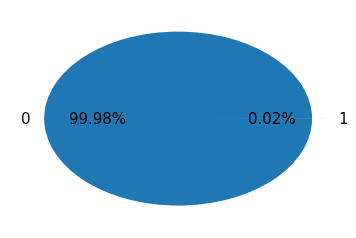

In [10]:
# 观察是否存在类别不平衡现象
        
p=df_train['ZHIWU'].value_counts()

# 目标变量正负样本的分布
figsize=(10,6)
plt.figure()

#绘制饼图看占比
patches,l_text,p_text=plt.pie(p,labels=['0','1'],autopct='%1.2f%%',explode=(0,0.1))
for t in p_text:
    t.set_size(15)
for t in l_text:
    t.set_size(15)
plt.show()

import pandas as pd
pd.show_versions()
pd.__version__

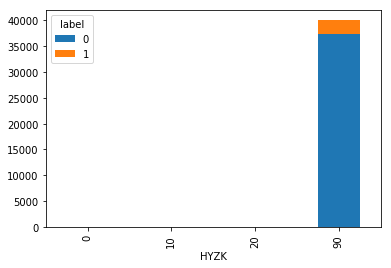

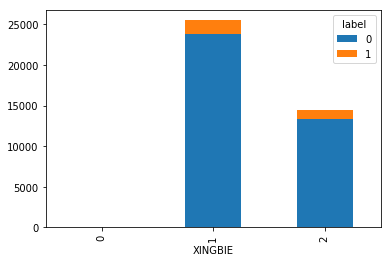

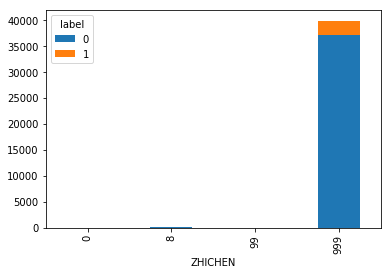

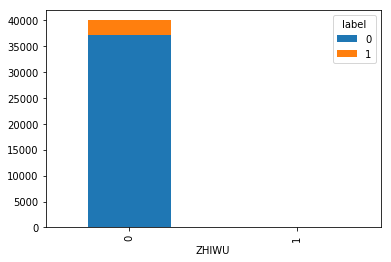

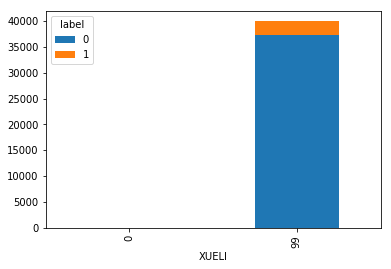

In [11]:
#基本特征对标签影响  若同一个特征的值不同，标签占比相同，则无影响
basecols=['HYZK','XINGBIE','ZHICHEN','ZHIWU','XUELI']
for i in basecols:
    cnt=pd.crosstab(df_train[i],df_train['label'])
    cnt.plot.bar(stacked=True)
    plt.show()


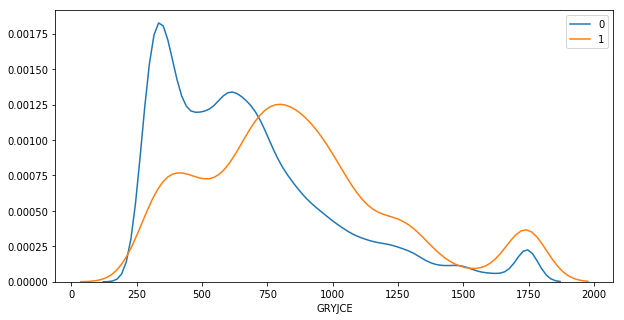

In [12]:
#每月费用核密度估计图
plt.figure(figsize=(10,5))

negDf=df_train[df_train['label']==0]
sns.distplot(negDf['GRYJCE'],hist=False,label=0)
posDf=df_train[df_train['label']==1]
sns.distplot(posDf['GRYJCE'],hist=False,label=1)

个人月缴费用越高，公积金失信概率越大

In [13]:
#训练集和测试集比较  

def eda_stat(train, test):
    result = {'variable': [],
              'dtype': [],
              'nunique_train': [],
              'nunique_test': [],
              'same_in_test': [],
              'null_ratio_train': [],
              'null_ratio_test': []}
    for i in test.columns:
        trn_ = set(train[i].unique())
        tst_ = set(test[i].unique())
        result['variable'].append(i)
        result['dtype'].append(train[i].dtype)
        result['nunique_train'].append(train[i].nunique())
        result['nunique_test'].append(test[i].nunique())
        result['same_in_test'].append(1.0*len(trn_&tst_)/len(tst_)) #test中的取值和train中的重合比例
        result['null_ratio_train'].append(1.0*train[i].isnull().sum()/train.shape[0])
        result['null_ratio_test'].append(1.0*test[i].isnull().sum()/test.shape[0])
    result = pd.DataFrame(result)
    result = result[['variable', 'dtype', 'nunique_train', 'nunique_test', 'same_in_test', 'null_ratio_train', 'null_ratio_test']]
    return result 

eda_stat(df_train, df_test)


,variable,dtype,nunique_train,nunique_test,same_in_test,null_ratio_train,null_ratio_test
0,id,object,40000,15000,0.000000,0.0,0.0
1,XINGBIE,int64,3,3,1.000000,0.0,0.0
2,CSNY,int64,393,371,0.975741,0.0,0.0
3,HYZK,int64,4,1,1.000000,0.0,0.0
4,ZHIYE,int64,7,4,1.000000,0.0,0.0
5,ZHICHEN,int64,4,2,1.000000,0.0,0.0
6,ZHIWU,int64,2,2,1.000000,0.0,0.0
7,XUELI,int64,2,1,1.000000,0.0,0.0
8,DWJJLX,int64,28,27,1.000000,0.0,0.0
9,DWSSHY,int64,21,21,1.000000,0.0,0.0


In [14]:
pos_user = list(df_train[df_train['label']==1]['id'].unique())
neg_user = list(df_train[df_train['label']==0]['id'].unique())

#不同特征值比例
df_train[df_train['id'].isin(neg_user)]['XINGBIE'].value_counts(normalize=True).head(15)  
df_train[df_train['id'].isin(neg_user)]['HYZK'].value_counts(normalize=True).head(15)

90    0.999678
0     0.000161
10    0.000134
20    0.000027
Name: HYZK, dtype: float64

In [14]:
a=['1' ,'2' ,'3' ,'4','5']
b=[a for a in a if a=='2']
print(a)
print(b)

['1', '2', '3', '4', '5']
['2']


In [15]:

list = [10086,'d',[1,2,3]]
print(len(list))
print(list)
print(list.pop())
print(len(list))
print(list)


3
[10086, 'd', [1, 2, 3]]
[1, 2, 3]
2
[10086, 'd']


In [17]:
listt = [[1,2,3],
         [4,5,6],
         [7,8,9]]
print(listt)
print(listt[1])

col2 = [col[0] for col in listt]      #   此时 col是listt的一个元素，
print(col2)       #     然后col[0]就是这个元素的第一个值，因此 col2=listt中每个元素的第一个值

col22 = [col[2] for col in listt if col[2] % 2 == 0]
print(col22)
print(listt[0][2])
print(listt[1][2])
print(listt[2][2])

SyntaxError: invalid syntax (<ipython-input-17-63a47f2020f4>, line 10)